# Pneumonia Identification Project

# Business and Data Understanding


# Data preparation

In [1]:
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np

In [2]:
# Linking directory path
train_data_dir = 'data/chest_xray/train'
val_data_dir = 'data/chest_xray/val'
test_data_dir = 'data/chest_xray/test'

In [3]:
# Getting train, test, and validation data from directory
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir,
                                                           target_size=(64, 64),
                                                           batch_size=5000,
                                                           seed=42)

test_generator = ImageDataGenerator().flow_from_directory(test_data_dir,
                                                          target_size=(64, 64),
                                                          batch_size=624,
                                                          seed=42)

val_generator = ImageDataGenerator().flow_from_directory(val_data_dir,
                                                         target_size=(64, 64),
                                                         batch_size=232,
                                                         seed=42)

Found 5000 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 232 images belonging to 2 classes.


In [4]:
# Creating datasets, takes about a minute to run.
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [5]:
# Reshaping data
train_img_unrow = train_images.reshape(5000, -1)
test_img_unrow = test_images.reshape(624, -1)
val_img_unrow = val_images.reshape(232, -1)

In [6]:
print(np.shape(train_img_unrow))
print(np.shape(test_img_unrow))
print(np.shape(val_img_unrow))

(5000, 12288)
(624, 12288)
(232, 12288)


In [7]:
# Normalizing data
train_img_final = train_img_unrow/255.0
test_img_final = test_img_unrow/255.0
val_img_final = val_img_unrow/255.0

# Modeling

In [296]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [10]:
model_1 = Sequential()

In [11]:
model_1.add(layers.Input(shape=(12288,)))
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(25, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(2, activation='softmax'))

In [12]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
model_1_results = model_1.fit(train_img_final, train_labels,
                              epochs=10,
                              batch_size=125, 
                              validation_data=(val_img_final, val_labels))

Epoch 1/10
40/40 [==============================] - 0s 6ms/step - loss: 0.5733 - accuracy: 0.7224 - val_loss: 0.6072 - val_accuracy: 0.5905
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3627 - accuracy: 0.8444 - val_loss: 0.5314 - val_accuracy: 0.7328
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.2398 - accuracy: 0.9090 - val_loss: 0.3705 - val_accuracy: 0.8405
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.1902 - accuracy: 0.9250 - val_loss: 0.3747 - val_accuracy: 0.8276
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.1460 - accuracy: 0.9472 - val_loss: 0.2628 - val_accuracy: 0.8966
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.1420 - accuracy: 0.9480 - val_loss: 0.2477 - val_accuracy: 0.8879
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.1198 - accuracy: 0.9574 - val_loss: 0.2949 - val_accuracy: 0.8621
Epoch 8/10
40/40 [==

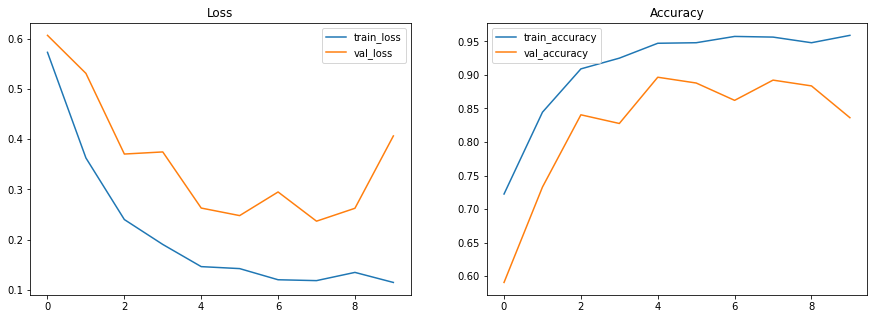

In [14]:
plot_results([model_1_results])

In [15]:
model_2 = Sequential()

In [16]:
model_2.add(layers.Input(shape=(12288,)))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(25, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(10, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(2, activation='softmax'))

In [17]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model_2_results = model_2.fit(train_img_final, train_labels,
                              epochs=50,
                              batch_size=300, 
                              validation_data=(val_img_final, val_labels))

Epoch 1/50
17/17 [==============================] - 0s 10ms/step - loss: 0.7237 - accuracy: 0.6844 - val_loss: 0.6029 - val_accuracy: 0.5000
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5034 - accuracy: 0.7778 - val_loss: 0.6105 - val_accuracy: 0.5474
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.4573 - accuracy: 0.7800 - val_loss: 0.4347 - val_accuracy: 0.8578
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.3988 - accuracy: 0.8502 - val_loss: 0.5008 - val_accuracy: 0.7414
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.3670 - accuracy: 0.8666 - val_loss: 0.5207 - val_accuracy: 0.7716
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 0.3213 - accuracy: 0.8898 - val_loss: 0.4601 - val_accuracy: 0.8276
Epoch 7/50
17/17 [==============================] - 0s 6ms/step - loss: 0.2987 - accuracy: 0.8968 - val_loss: 0.3338 - val_accuracy: 0.8362
Epoch 8/50
17/17 [=

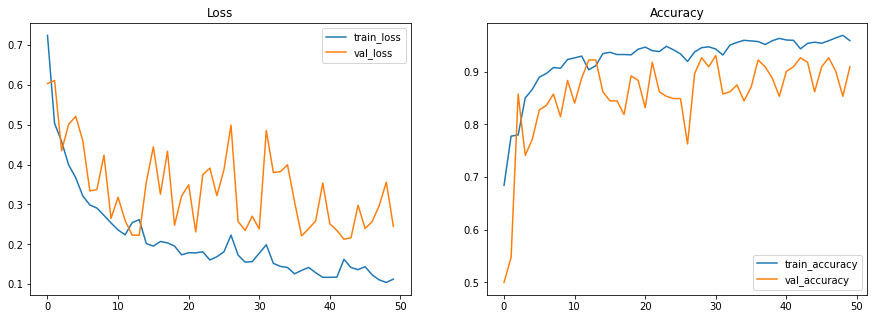

In [19]:
plot_results([model_2_results])

In [20]:
m2_test_results = model_2.evaluate(train_img_final, train_labels)

157/157 [==============================] - 0s 605us/step - loss: 0.0654 - accuracy: 0.9770


In [21]:
# Creating an earlystop variable
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [22]:
model_3 = Sequential()

In [23]:
model_3.add(layers.Input(shape=(12288,)))
model_3.add(Dense(50, activation='relu'))
model_3.add(Dense(50, activation='relu', kernel_regularizer=l2(l2=0.5)))
model_3.add(Dropout(0.5))
model_3.add(Dense(25, activation='relu'))
model_3.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.25)))
model_3.add(Dropout(0.2))
model_3.add(Dense(10, activation='relu'))
model_3.add(Dense(2, activation='softmax'))

In [24]:
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model_3_results = model_3.fit(train_img_final, train_labels,
                              epochs=40, 
                              batch_size=350,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[early_stop])

Epoch 1/40
15/15 [==============================] - 0s 11ms/step - loss: 30.6835 - accuracy: 0.5962 - val_loss: 27.9997 - val_accuracy: 0.5000
Epoch 2/40
15/15 [==============================] - 0s 6ms/step - loss: 25.6945 - accuracy: 0.7184 - val_loss: 23.3781 - val_accuracy: 0.5000
Epoch 3/40
15/15 [==============================] - 0s 7ms/step - loss: 21.4341 - accuracy: 0.7390 - val_loss: 19.5809 - val_accuracy: 0.5000
Epoch 4/40
15/15 [==============================] - 0s 6ms/step - loss: 17.8329 - accuracy: 0.7482 - val_loss: 16.3010 - val_accuracy: 0.5000
Epoch 5/40
15/15 [==============================] - 0s 6ms/step - loss: 14.8187 - accuracy: 0.7510 - val_loss: 13.6216 - val_accuracy: 0.5000
Epoch 6/40
15/15 [==============================] - 0s 6ms/step - loss: 12.2828 - accuracy: 0.7528 - val_loss: 11.2925 - val_accuracy: 0.5000
Epoch 7/40
15/15 [==============================] - 0s 6ms/step - loss: 10.1696 - accuracy: 0.7528 - val_loss: 9.3899 - val_accuracy: 0.5000
Epoch 

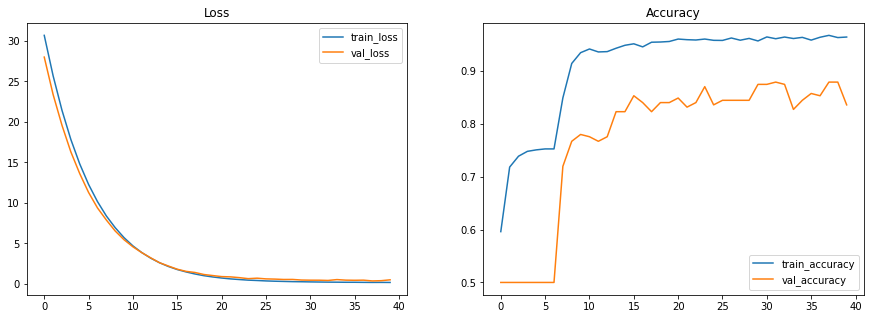

In [26]:
plot_results([model_3_results])

In [27]:
model_4 = Sequential()

In [28]:
model_4.add(layers.Input(shape=(12288,)))
model_4.add(Dense(75, activation='relu'))
model_4.add(Dense(50, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(50, activation='relu', kernel_regularizer=l2(l2=0.5)))
model_4.add(Dense(25, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.25)))
model_4.add(Dense(10, activation='relu', kernel_regularizer=l2(l2=0.01)))
model_4.add(Dense(2, activation='softmax'))

In [29]:
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
model_4_results = model_4.fit(train_img_final, train_labels,
                              epochs=50,
                              batch_size=250,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[early_stop])

Epoch 1/50
20/20 [==============================] - 0s 9ms/step - loss: 28.8760 - accuracy: 0.3402 - val_loss: 25.4138 - val_accuracy: 0.5000
Epoch 2/50
20/20 [==============================] - 0s 6ms/step - loss: 22.7420 - accuracy: 0.6712 - val_loss: 20.0869 - val_accuracy: 0.5000
Epoch 3/50
20/20 [==============================] - 0s 6ms/step - loss: 17.8741 - accuracy: 0.7356 - val_loss: 15.8857 - val_accuracy: 0.5000
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 14.0203 - accuracy: 0.7522 - val_loss: 12.4779 - val_accuracy: 0.5000
Epoch 5/50
20/20 [==============================] - 0s 6ms/step - loss: 10.9641 - accuracy: 0.7534 - val_loss: 9.8111 - val_accuracy: 0.5000
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 8.5350 - accuracy: 0.7550 - val_loss: 7.6886 - val_accuracy: 0.5000
Epoch 7/50
20/20 [==============================] - 0s 6ms/step - loss: 6.6176 - accuracy: 0.7768 - val_loss: 5.9779 - val_accuracy: 0.5517
Epoch 8/50


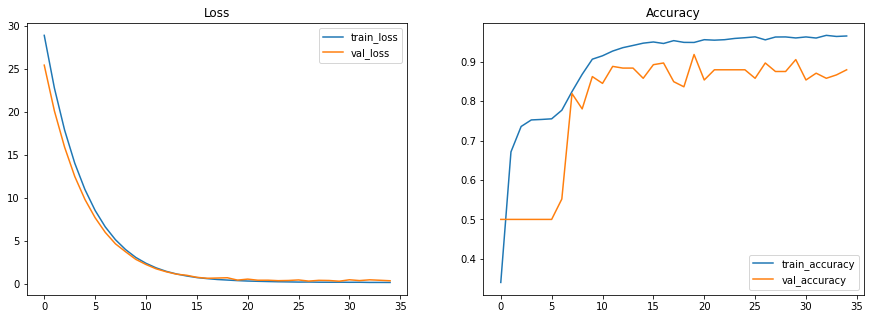

In [31]:
plot_results([model_4_results])

In [32]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_lr=1e-5)

In [284]:
model_5 = models.Sequential()

In [285]:
model_5.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))
model_5.add(layers.BatchNormalization())

model_5.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2=0.0001)))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dropout(0.5))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid', kernel_regularizer=l2(l2=0.00001)))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Flatten())
model_5.add(layers.Dense(2, activation='softmax'))

In [286]:
model_5.compile(Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

In [287]:
model_5_results = model_5.fit(train_images, train_labels,
                              epochs=15,
                              batch_size=324,
                              validation_data=(val_images, val_labels),
                              callbacks=[early_stop, reduce_lr])

Epoch 1/15
16/16 [==============================] - 7s 427ms/step - loss: 0.4514 - accuracy: 0.8004 - val_loss: 1.0618 - val_accuracy: 0.5000
Epoch 2/15
16/16 [==============================] - 7s 421ms/step - loss: 0.2187 - accuracy: 0.9116 - val_loss: 0.5625 - val_accuracy: 0.5905
Epoch 3/15
16/16 [==============================] - 7s 418ms/step - loss: 0.1662 - accuracy: 0.9318 - val_loss: 0.4483 - val_accuracy: 0.8190
Epoch 4/15
16/16 [==============================] - 7s 416ms/step - loss: 0.1407 - accuracy: 0.9470 - val_loss: 0.4058 - val_accuracy: 0.9138
Epoch 5/15
16/16 [==============================] - 7s 419ms/step - loss: 0.1246 - accuracy: 0.9538 - val_loss: 0.3736 - val_accuracy: 0.8922
Epoch 6/15
16/16 [==============================] - 7s 418ms/step - loss: 0.1108 - accuracy: 0.9564 - val_loss: 0.4092 - val_accuracy: 0.8319
Epoch 7/15
16/16 [==============================] - 7s 419ms/step - loss: 0.1024 - accuracy: 0.9636 - val_loss: 0.3312 - val_accuracy: 0.8836
Epoch 

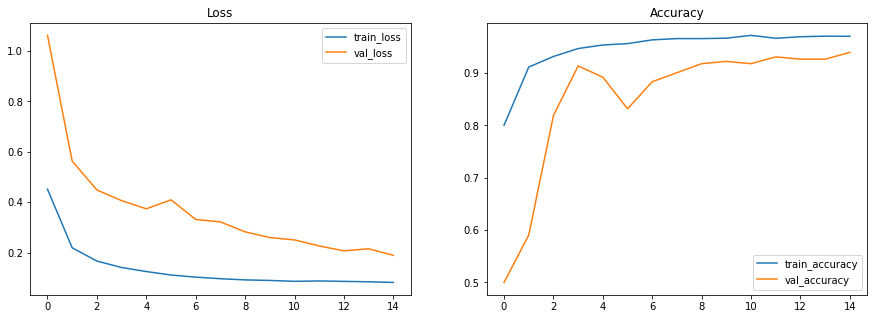

In [288]:
plot_results([model_5_results])

In [289]:
model_5.evaluate(train_images, train_labels)

157/157 [==============================] - 1s 9ms/step - loss: 0.1587 - accuracy: 0.9522


[0.15871407091617584, 0.9521999955177307]

In [290]:
model_5.evaluate(test_images, test_labels)

20/20 [==============================] - 0s 8ms/step - loss: 0.3021 - accuracy: 0.8734


[0.30207982659339905, 0.8733974099159241]

In [299]:
test_img_pred = model_5.predict(test_images)

# Evaluation